### Data preprocessing

In [17]:
import pandas as pd 
from pandas import DataFrame
from pandas import concat
from sklearn.metrics import mean_absolute_percentage_error as mape, root_mean_squared_error as rmse, mean_absolute_error as mae, mean_squared_error as mse
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV

In [18]:
# Split: [0] = 80% 20% | [1] = 70% 30% | [2] = 90% 10%
split_type = [0.8,0.7,0.9]
# Stock [0] = FPT | [1] = CMG | [2] = ITD
stock_name = ["FPT", "CMG", "ITD"]

In [19]:
#Change stock and split to adjust between splitting type and stock
stock = 1
split = 0

In [20]:
#Loading data 
df = pd.read_csv(f"../../dataset/{stock_name[stock]}_stock.csv")
df = df[['close']]
df = df.reset_index(drop=True)
df.head(10)

,close
0,13480
1,13970
2,14460
3,14060
4,13830
5,13990
6,13870
7,14490
8,14490
9,14490


In [21]:
#Defining the split size
train_size = int(split_type[split] * len(df))
test_size = len(df) - train_size

In [22]:
#splitting data into train, test set
train_data = df[:train_size].values
test_data = df[train_size:].values

In [23]:
# Function to create dataset input and output, it will convert an array of values into a dataset matrix, use the sliding window with the time_step argument
def create_dataset(data, WINDOW_SLIDE):
    X, y = [], []

    for i in range(len(data) - WINDOW_SLIDE - 1):
        X.append(data[i : (i + WINDOW_SLIDE), 0])
        y.append(data[i + WINDOW_SLIDE, 0])

    return np.array(X), np.array(y)

In [24]:
# Define time step, it mean the model will take 10 days before to predict the closing price 'at that time'
WINDOW_SLIDE = 10

# Create X, y for train, test and validate
X_train, y_train = create_dataset(train_data, WINDOW_SLIDE)
X_test, y_test = create_dataset(test_data, WINDOW_SLIDE)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((1039, 10), (1039,), (252, 10), (252,))

### Building and training GBR model

In [25]:
gbr = GradientBoostingRegressor(
    n_estimators=150,
    learning_rate=0.1,
    max_depth=1,
    criterion='friedman_mse',
    random_state=0,
)

gbr.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=1, n_estimators=150, random_state=0)

### Predicting and forecasting using GBR model

In [26]:
#Predicting using test set, validation set
y_test_pred = gbr.predict(X_test)

In [27]:
def forecast(data, window_slide, forecast_days):
    # Get the last sequence_length days
    x_forecast = data[-window_slide:]
    y_forecast = []

    for i in range(forecast_days + 1):
        # Reshape x_forecast to have the shape (1, window_side)
        x_forecast_reshaped = x_forecast.reshape(1, window_slide)
        # Predict the next day
        y = gbr.predict(x_forecast_reshaped)
        y_forecast.append(y[0])

        # Add the new prediction to the data
        x_forecast = np.insert(x_forecast, -1, y, axis=0)[1:]

    return y_forecast

In [28]:
y_pred_30_days = forecast(test_data, WINDOW_SLIDE, 30)
y_pred_60_days = forecast(test_data, WINDOW_SLIDE, 60)
y_pred_90_days = forecast(test_data, WINDOW_SLIDE, 90)

In [29]:
# Splitting data into train, test and validation set again to visualize the predictions result
train_data1 = df[:train_size]
test_data1 = df[train_size : train_size + test_size]
X_test1 = np.array(test_data1.index).reshape(-1, 1)

In [30]:
def draw_plot(y_days_predict, days):
    plt.figure(figsize=(10, 6))
    plt.ylabel("Closing Price")

    # Raw data
    plt.plot(train_data1.index, train_data1, label="Train")
    plt.plot(test_data1.index, test_data1, label="Test")

    # Predict test and validate
    plt.plot(
        test_data1.index[
            WINDOW_SLIDE : len(y_test_pred) + WINDOW_SLIDE
        ],  # because using the sliding window (WINDOW_SIDE) -> the index of 2 dataset is difference
        y_test_pred,
        label="Predicted Test",
        linestyle="--",
    )
    # Predict the next 30/60/90 days
    plt.plot(
        test_data1.index[-1] + np.arange(1, len(y_days_predict) + 1),
        y_days_predict,
        label=f"Predicted Next {days} Days",
        linestyle="--",
    )

    plt.title(f"{stock_name[stock]} Stock Closing Price Prediction Using GBR")
    plt.legend()
    plt.show()

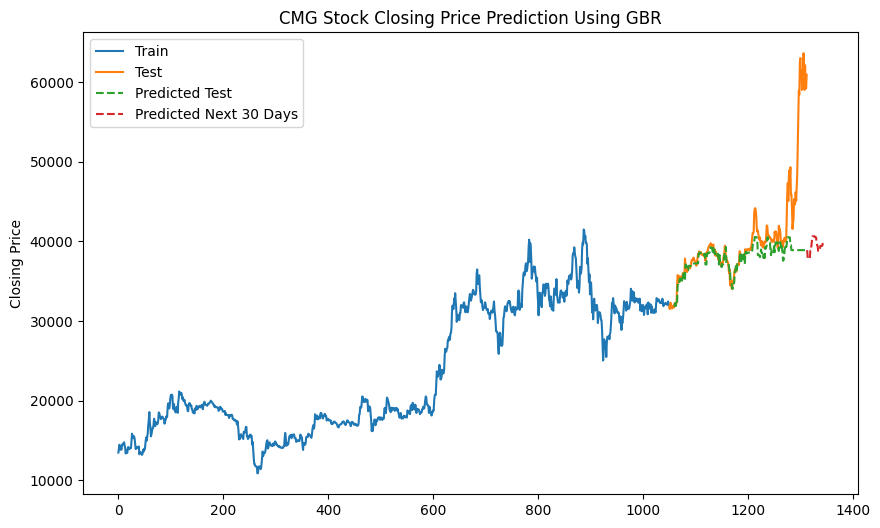

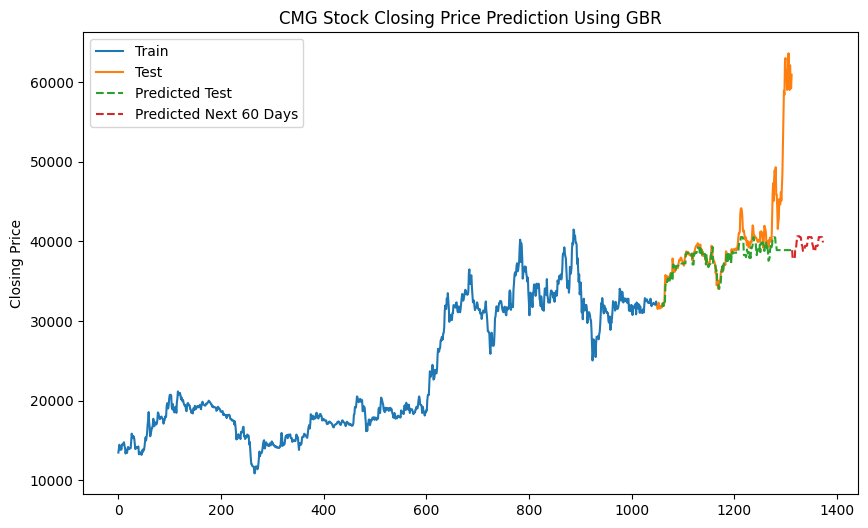

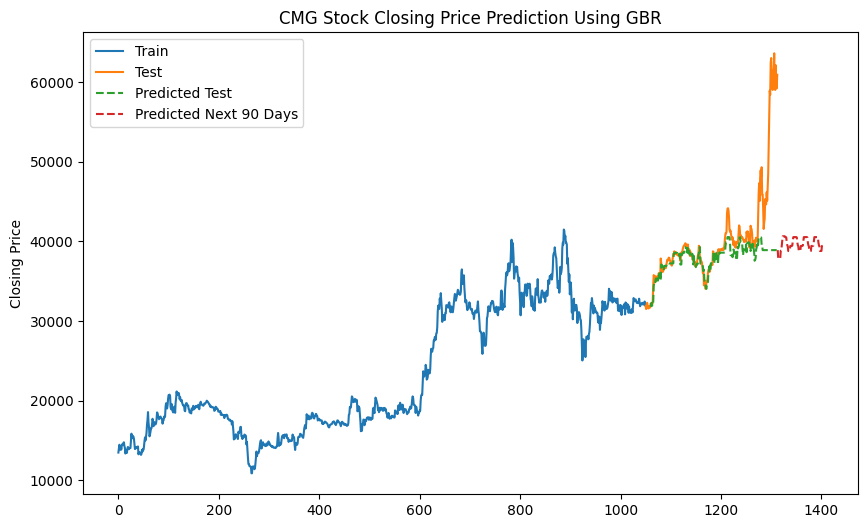

In [31]:
draw_plot(y_pred_30_days, 30)
draw_plot(y_pred_60_days, 60)
draw_plot(y_pred_90_days, 90)

In [32]:
# Model evaluation on test set
print(f"MSE on test data: {mse (y_test, y_test_pred)}")
print(f"MAPE on test data: {mape(y_test, y_test_pred) * 100}%")
print(f"RMSE on test data: {rmse(y_test, y_test_pred)}")
print(f"MAE on test data: {mae(y_test, y_test_pred)}")

MSE on test data: 34638872.67930331
MAPE on test data: 5.133132811305568%
RMSE on test data: 5885.479817253927
MAE on test data: 2586.670201491382
